In [1]:
!pip install transformers
!pip install sentencepiece
!pip3 install mvlearn

from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
os.chdir('drive/MyDrive/William_2022/DATASETS/main_trans_ZuCo_sent')

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from model_new import Transformer, Transformer2, Encoder
from config import *
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm import tqdm
from optim_new import ScheduledOptim
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from CCA import DeepCCA, cca_loss
from scipy.stats import wasserstein_distance
from mvlearn.embed import DCCA
from mvlearn.datasets import make_gaussian_mixture
from mvlearn.plotting import crossviews_plot
from dataset_new import Fusion
import matplotlib.pylab as pl
import ot
import ot.plot
from mvlearn.plotting import quick_visualize
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns

In [44]:
# --- load ZuCo sentence

#normal

X_val_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_pred_val.txt')
X_test_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_pred.txt')

y_val_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_label_val.txt')
y_test_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_label.txt')

X_val_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_pred_val.txt')
X_test_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_pred.txt')

y_val_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_label_val.txt')
y_test_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_label.txt')

#DCCA

X_val_DCCA_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred_val.txt')
X_test_DCCA_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred_test.txt')

X_val_DCCA_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred2_val.txt')
X_test_DCCA_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred2_test.txt')

y_val_DCCA = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_label_val.txt')
y_test_DCCA = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_label_test.txt')

#DCCA fusion

X_val_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_pred_val.txt')
X_test_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_pred.txt')

y_val_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_label_val.txt')
y_test_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_label.txt')

#DCCA ds

X_val_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred_val.txt')
X_test_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred.txt')

y_val_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label_val.txt')
y_test_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label.txt')

X_val_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred_val.txt')
X_test_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred.txt')

y_val_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label_val.txt')
y_test_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label.txt')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.208743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.591400
[t-SNE] KL divergence after 5000 iterations: 0.678943


[Text(0.5, 1.0, 'Normal Text T-SNE projection')]

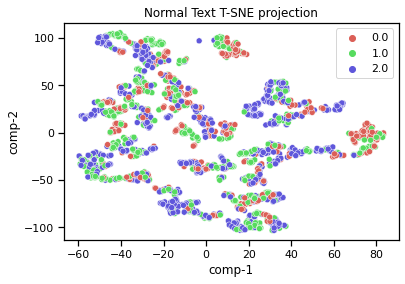

In [192]:
#norm text
x = X_val_text[10200:]
y = y_val_text[10200:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 15, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Normal Text T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.001934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.286533
[t-SNE] KL divergence after 5000 iterations: 0.328402


[Text(0.5, 1.0, 'Normal EEG T-SNE projection')]

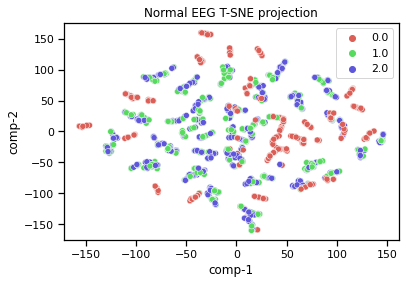

In [217]:
#norm eeg
x = X_val_eeg[:1600]
y = y_val_eeg[:1600]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 5, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Normal EEG T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.034264
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.442062
[t-SNE] KL divergence after 5000 iterations: 0.759153


[Text(0.5, 1.0, 'DCCA Text T-SNE projection')]

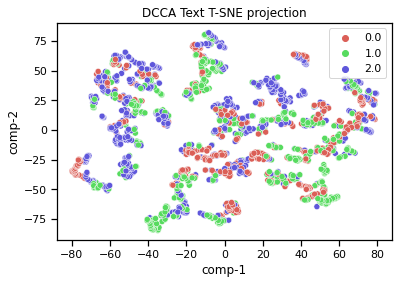

In [224]:
#DCCA Text
x = X_val_DCCA_text[10200:]
y = y_val_DCCA[10200:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 14, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA Text T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.000075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.290237
[t-SNE] KL divergence after 5000 iterations: 0.231827


[Text(0.5, 1.0, 'DCCA EEG T-SNE projection')]

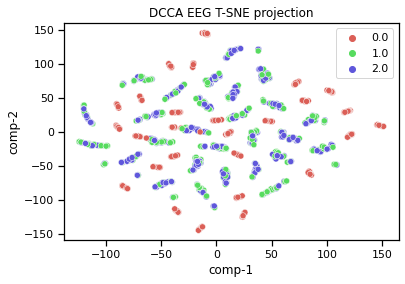

In [223]:
#DCCA EEG
x = X_val_DCCA_eeg[10200:]
y = y_val_DCCA[10200:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 7, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA EEG T-SNE projection"
                             ) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.003s...
[t-SNE] Computed neighbors for 1600 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.158025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.365181
[t-SNE] KL divergence after 5000 iterations: 0.539582


[Text(0.5, 1.0, 'DCCA Fusion T-SNE projection')]

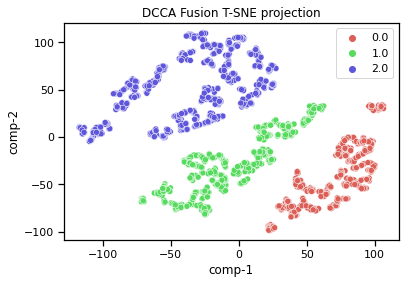

In [222]:
#DCCA Fusion
x = X_val_DCCA_fusion[10200:]
y = y_val_DCCA_fusion[10200:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 9, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA Fusion T-SNE projection") 